In [9]:
import flow2graph
from pathlib import Path
import networkx as nx

import torch
import dgl
import numpy as np

In [10]:
import dgl.nn as dglnn
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F

class EdgeToNode(nn.Module):
    def __init__(self, in_features, out_features, non_linear=None):
        super().__init__()
#         with torch.no_grad():
#             self.linear_in.weight.data = (torch.ones_like(self.linear_in.weight.data))
#             self.linear_out.weight.data = (-2 * torch.ones_like(self.linear_out.weight.data))
        
    def forward(self, graph: dgl.DGLGraph, h):
        h_in = h
        h_out = -2 * h
        
        with graph.local_scope(): 
            graph.edata['e_in'] = h_in
            graph.edata['e_out'] = h_out
            
            # copying `e_in` edge feature to dst node + aggregating with sum into `n_in`
            graph.update_all(fn.copy_e('e_in', 'n_in'), fn.sum('n_in', 'n_in')) 
            
            # reversing the graph so that src nodes become dst nodes
            r_graph = graph.reverse(copy_ndata=True, copy_edata=True) 
            # copying `e_out` edge feature to src node + aggregating with sum into `n_in`
            r_graph.update_all(fn.copy_e('e_out', 'n_out'), fn.sum('n_out', 'n_out')) 
            
            return graph.ndata['n_in'] + r_graph.ndata['n_out']

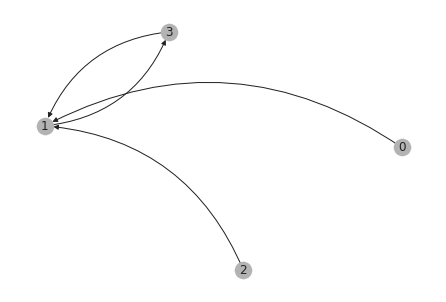

In [14]:
import networkx as nx

e2n = EdgeToNode(in_features=1, out_features=2)

uv = [0, 1, 2, 3], [1, 3, 1, 1]
G = dgl.graph(uv)
G.edata['w'] = torch.tensor([10., 2., -3., 5.])
G.ndata['h'] = e2n(G, G.edata['w'])

nx_G = G.to_networkx(node_attrs=['h'], edge_attrs=['w']).to_directed()
pos = nx.spring_layout(nx_G)
# labels = nx.get_edge_attributes(nx_G,'w')
# nx.draw_networkx_edge_labels(nx_G,pos,edge_labels=labels)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]], connectionstyle='arc3, rad = 0.3')

In [15]:
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
# labels.items()
# for a, b, label in nx.get_edge_attributes(nx_G,'w'):
#     print(a, b, label)
G.ndata['h']

tensor([-20.,   8.,   6.,  -8.])